In [1]:
from emukit.test_functions import forrester_function
from emukit.core import ParameterSpace, ContinuousParameter
import numpy as np
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import matplotlib.pyplot as plt
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
%load_ext autoreload
%autoreload 2

# COVID-19 Analysis Using Data From Marseille, France 

- It mainly consists of three parts:
    - data cleaning
    - bayesian optimization step by step
    - automatic bayesian optimization

## Data Cleaning

In [3]:
import pandas as pd
import numpy as np

In [4]:
# read data
mar_data = pd.read_csv("dataIHU.csv")
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,No,NaN,No,31,NEG,NEG,NEG,NEG,NEG,NEG
1,2,12,F,Asymptomatic,NaN,No,NaN,No,26,ND,33,34,NEG,34,NEG
2,3,14,F,Asymptomatic,NaN,No,NaN,No,26,31,23,22,27,NEG,26
3,4,10,M,Asymptomatic,NaN,No,NaN,No,24,NEG,33,33,NEG,NEG,32
4,5,20,M,upper tract respiratory infection,4.0,No,NaN,No,24,24,24,27,NEG,31,29
5,6,65,F,upper tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,ND,POS
6,7,46,M,upper tract respiratory infection,NaN,No,NaN,No,28,ND,ND,ND,26,ND,30
7,8,69,M,lower tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,POS,POS
8,9,62,F,lower tract respiratory infection,10.0,No,NaN,No,POS,ND,POS,ND,POS,ND,POS
9,10,66,F,upper tract respiratory infection,0.0,No,NaN,No,POS,ND,POS,ND,ND,ND,POS


In [5]:
# Convert NEG in Day 6 to 0
converter_1 = lambda x: 0 if x == 'NEG' else x
converter_2 = lambda x: 1 if x == 'POS' else x
converter_3 = lambda x: 0 if x == 'ND' else 1
mar_data['D6'] = mar_data['D6'].apply(converter_1)
mar_data['D6'] = mar_data['D6'].apply(converter_2)
mar_data['D6'] = mar_data['D6'].apply(converter_3)
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,No,NaN,No,31,NEG,NEG,NEG,NEG,NEG,1
1,2,12,F,Asymptomatic,NaN,No,NaN,No,26,ND,33,34,NEG,34,1
2,3,14,F,Asymptomatic,NaN,No,NaN,No,26,31,23,22,27,NEG,1
3,4,10,M,Asymptomatic,NaN,No,NaN,No,24,NEG,33,33,NEG,NEG,1
4,5,20,M,upper tract respiratory infection,4.0,No,NaN,No,24,24,24,27,NEG,31,1
5,6,65,F,upper tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,ND,1
6,7,46,M,upper tract respiratory infection,NaN,No,NaN,No,28,ND,ND,ND,26,ND,1
7,8,69,M,lower tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,POS,1
8,9,62,F,lower tract respiratory infection,10.0,No,NaN,No,POS,ND,POS,ND,POS,ND,1
9,10,66,F,upper tract respiratory infection,0.0,No,NaN,No,POS,ND,POS,ND,ND,ND,1


In [6]:
# convert hydroxychloquine treatment to number
converter_hy = lambda x: 0 if x == 'No' else 1
mar_data['Hydroxychloroquine\ntreatment'] = mar_data['Hydroxychloroquine\ntreatment'].apply(converter_hy)
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,0,NaN,No,31,NEG,NEG,NEG,NEG,NEG,1
1,2,12,F,Asymptomatic,NaN,0,NaN,No,26,ND,33,34,NEG,34,1
2,3,14,F,Asymptomatic,NaN,0,NaN,No,26,31,23,22,27,NEG,1
3,4,10,M,Asymptomatic,NaN,0,NaN,No,24,NEG,33,33,NEG,NEG,1
4,5,20,M,upper tract respiratory infection,4.0,0,NaN,No,24,24,24,27,NEG,31,1
5,6,65,F,upper tract respiratory infection,2.0,0,NaN,No,POS,ND,POS,ND,POS,ND,1
6,7,46,M,upper tract respiratory infection,NaN,0,NaN,No,28,ND,ND,ND,26,ND,1
7,8,69,M,lower tract respiratory infection,2.0,0,NaN,No,POS,ND,POS,ND,POS,POS,1
8,9,62,F,lower tract respiratory infection,10.0,0,NaN,No,POS,ND,POS,ND,POS,ND,1
9,10,66,F,upper tract respiratory infection,0.0,0,NaN,No,POS,ND,POS,ND,ND,ND,1


In [7]:
# column selection
selected = mar_data[['Hydroxychloroquine\ntreatment', 'D6']]
selected

,Hydroxychloroquine\ntreatment,D6
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1


## Build a Bayesian Model

In [8]:
# uniform sample from "selected"
sample_X = selected.sample(frac = 0.7, replace = False)
sample_X = np.array(sample_X)
sample_X

array([[1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [1, 1]], dtype=int64)

In [20]:
# define the test function
def f():
    """
    :return: Tuple of function and parameter space object
    """
    def actual_func(x):
        return target_func(x)
    return actual_func

def target_func(x):
    """
    the actual function
    
    :param x: input vector to be evaluated
    :return: outputs of the function
    """
    x = x.reshape((len(x), 2))
    
    # with treatment
    with_treatment = 0
    with_cured = 0
    for t in x:
        if t[0] == 1:
            with_treatment += 1
            if t[1] == 0:
                with_cured += 1
    if with_treatment != 0:
        w_prob = with_cured / with_treatment
    else:
        w_prob = 1
    
    #without treatment
    without_treatment = 0
    without_cured = 0
    for t in x:
        if t[0] == 0:
            without_treatment += 1
            if t[1] == 0:
                without_cured += 1
    if without_treatment != 0:
        wo_prob = without_cured / without_treatment
    else: 
        wo_prob = 1

    fval = x.copy().astype(np.float)
    for t in fval:
        if t[0] == 0:
            t[1] = wo_prob
        else:
            t[1] = w_prob
    return fval[:, 1].reshape(-1, 1)
    
f = f()
space = ParameterSpace([ContinuousParameter('x', 0, 1)])

In [12]:
sample_X

array([[1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [1, 1]], dtype=int64)

In [21]:
# get y values accoridng to prior knowledge
sample_Y = f(sample_X)
sample_Y

array([[0.0625    ],
       [0.44444444],
       [0.44444444],
       [0.0625    ],
       [0.0625    ],
       [0.44444444],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.44444444],
       [0.0625    ],
       [0.44444444],
       [0.0625    ],
       [0.0625    ],
       [0.0625    ],
       [0.44444444],
       [0.44444444],
       [0.44444444],
       [0.0625    ],
       [0.44444444],
       [0.0625    ]])

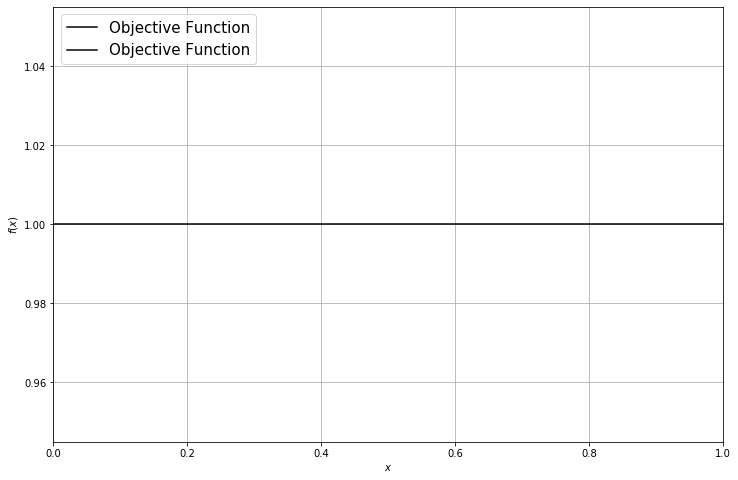

In [50]:
# plot of the objective function
x_plot = list(np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None])
for i in np.arange(len(x_plot)):
    t = x_plot[i]
    x_plot[i] = np.append(t, 0)
x_plot = np.array(x_plot)
y_plot = f(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

In [48]:
x_plot

array([[0.        , 0.        ],
       [0.00502513, 0.        ],
       [0.01005025, 0.        ],
       [0.01507538, 0.        ],
       [0.0201005 , 0.        ],
       [0.02512563, 0.        ],
       [0.03015075, 0.        ],
       [0.03517588, 0.        ],
       [0.04020101, 0.        ],
       [0.04522613, 0.        ],
       [0.05025126, 0.        ],
       [0.05527638, 0.        ],
       [0.06030151, 0.        ],
       [0.06532663, 0.        ],
       [0.07035176, 0.        ],
       [0.07537688, 0.        ],
       [0.08040201, 0.        ],
       [0.08542714, 0.        ],
       [0.09045226, 0.        ],
       [0.09547739, 0.        ],
       [0.10050251, 0.        ],
       [0.10552764, 0.        ],
       [0.11055276, 0.        ],
       [0.11557789, 0.        ],
       [0.12060302, 0.        ],
       [0.12562814, 0.        ],
       [0.13065327, 0.        ],
       [0.13567839, 0.        ],
       [0.14070352, 0.        ],
       [0.14572864, 0.        ],
       [0.

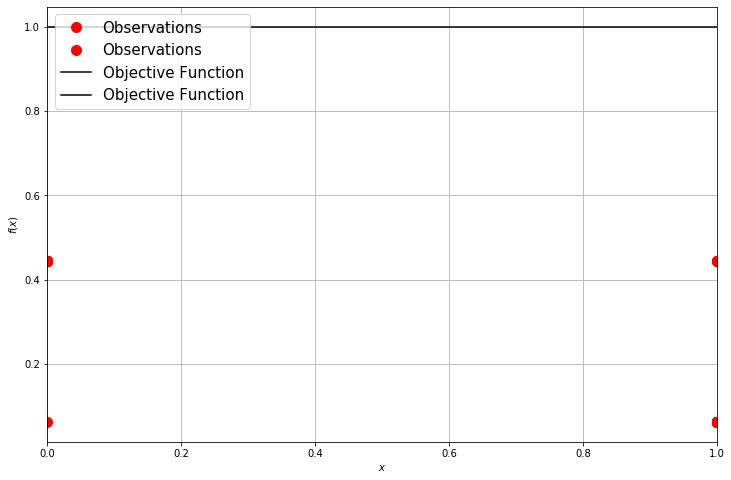

In [23]:
# plot of the initial design
plt.figure(figsize=(12, 8))
plt.plot(sample_X, sample_Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

 C:\Users\QYK\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


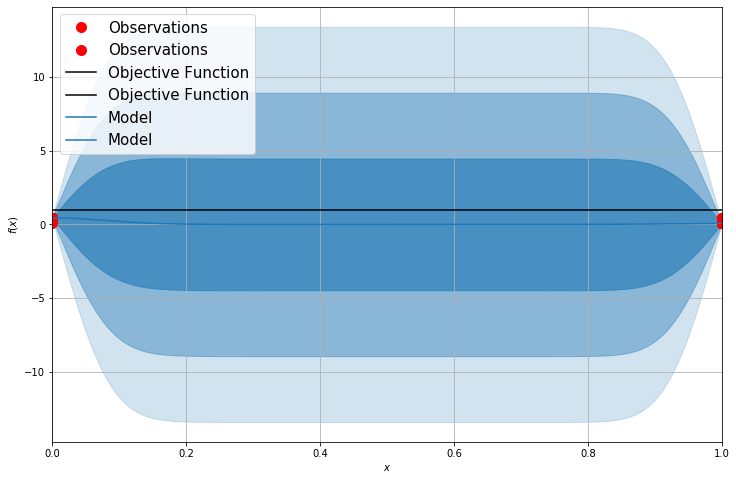

In [54]:
# build a model for the objective function
model_gpy = GPy.models.GPRegression(sample_X, sample_Y, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(model_gpy)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(sample_X, sample_Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

## Acqusition Function

In [26]:
# define an acquisition function able to quantify the utility of evaluating each point the input domain
ei_acquisition = ExpectedImprovement(emukit_model)

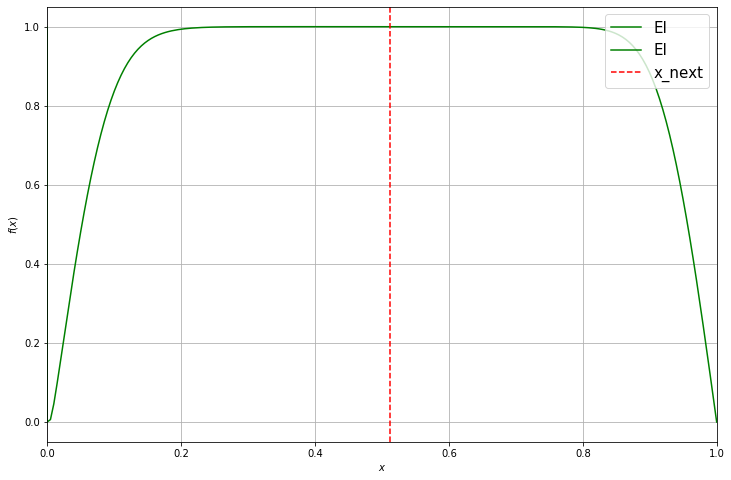

In [34]:
# evaluate the acquisition function and find the next point to evaluate
optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(ei_acquisition)
x_new = np.array([[x_new[0], 1]])
ei_plot = ei_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new[0][0], color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

In [35]:
# evaluate the objective function and append the result to initial observation
y_new = f(x_new)

X = np.append(sample_X, x_new, axis=0)
Y = np.append(sample_Y, y_new, axis=0)

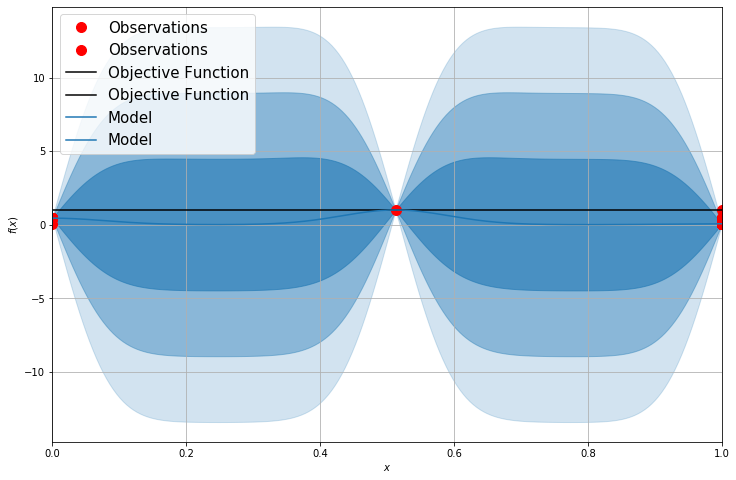

In [36]:
# update the model by setting new data
emukit_model.set_data(X, Y)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

- Observation: new data decreases the uncertainty of our data

## Loop through the optimization process

In [ ]:
for i in range(10):
    

## An Automatic Bayesian Optimization Loop Using Emukit

- The built in automation function requires the explanatory variables to be in shape of (-1, 1).
- Since our custom target function takes in an array of shape (-1, 2), it can not be applied to the automation function.

In [39]:
# Bayesian optimization loop
'''
bo = GPBayesianOptimization(variables_list = [ContinuousParameter('x', 0, 1)],
                            X = sample_X, Y = sample_Y)
bo.run_optimization(f, 10)
'''

"\nbo = GPBayesianOptimization(variables_list = [ContinuousParameter('x', 0, 1)],\n                            X = sample_X, Y = sample_Y)\nbo.run_optimization(f, 10)\n"

In [38]:
'''mu_plot, var_plot = bo.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(bo.loop_state.X, bo.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)

plt.show()
'''

'mu_plot, var_plot = bo.model.predict(x_plot)\n\nplt.figure(figsize=(12, 8))\nplt.plot(bo.loop_state.X, bo.loop_state.Y, "ro", markersize=10, label="Observations")\nplt.plot(x_plot, y_plot, "k", label="Objective Function")\nplt.plot(x_plot, mu_plot, "C0", label="Model")\nplt.fill_between(x_plot[:, 0],\n                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],\n                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)\n\nplt.fill_between(x_plot[:, 0],\n                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],\n                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)\n\nplt.fill_between(x_plot[:, 0],\n                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],\n                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)\nplt.legend(loc=2, prop={\'size\': 15})\nplt.xlabel(r"$x$")\nplt.ylabel(r"$f(x)$")\nplt.grid(True)\nplt.xlim(0, 1)\n\nplt.show()\n'